In [42]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [43]:
import numpy as np
import pandas as pd

In [44]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [45]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [46]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [47]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [48]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [49]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [50]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [51]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [52]:
columns = inspector.get_columns('measurement')
for c in columns:
   print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [53]:
columns = inspector.get_columns('station')
for c in columns:
   print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [54]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
inspector = inspect(engine)
inspector.get_table_names()



['measurement', 'station']

In [55]:
# Calculate the date 1 year ago from the last data point in the database

query_date = dt.date(2017, 8, 24) - dt.timedelta(days=365)
print("Query Date: ", query_date)

Query Date:  2016-08-24


In [56]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
meas_date_prcp = session.query(Measurement.date, Measurement.prcp).\
                  filter(Measurement.date > query_date).all()
meas_date_prcp

[('2016-08-25', 0.08),
 ('2016-08-26', 0.0),
 ('2016-08-27', 0.0),
 ('2016-08-28', 0.01),
 ('2016-08-29', 0.0),
 ('2016-08-30', 0.0),
 ('2016-08-31', 0.13),
 ('2016-09-01', 0.0),
 ('2016-09-02', 0.0),
 ('2016-09-03', 0.0),
 ('2016-09-04', 0.03),
 ('2016-09-05', None),
 ('2016-09-06', None),
 ('2016-09-07', 0.05),
 ('2016-09-08', 0.0),
 ('2016-09-09', 0.03),
 ('2016-09-10', 0.0),
 ('2016-09-11', 0.05),
 ('2016-09-12', 0.0),
 ('2016-09-13', 0.02),
 ('2016-09-14', 1.32),
 ('2016-09-15', 0.42),
 ('2016-09-16', 0.06),
 ('2016-09-17', 0.05),
 ('2016-09-18', 0.0),
 ('2016-09-19', 0.0),
 ('2016-09-20', 0.0),
 ('2016-09-21', 0.0),
 ('2016-09-22', 0.02),
 ('2016-09-23', 0.0),
 ('2016-09-24', 0.0),
 ('2016-09-25', 0.0),
 ('2016-09-26', 0.06),
 ('2016-09-27', 0.02),
 ('2016-09-28', 0.0),
 ('2016-09-29', 0.0),
 ('2016-09-30', 0.0),
 ('2016-10-01', 0.0),
 ('2016-10-02', 0.0),
 ('2016-10-03', 0.0),
 ('2016-10-04', 0.0),
 ('2016-10-05', 0.0),
 ('2016-10-06', 0.0),
 ('2016-10-07', 0.0),
 ('2016-10-08',

In [57]:
# Use Pandas Plotting with Matplotlib to plot the data
df = pd.DataFrame(meas_date_prcp, columns=['Date', 'Precipitation'])
df = df.sort_values("Date")
df.set_index(df['Date'], inplace=True)
df.head()



,Date,Precipitation
Date,,
2016-08-25,2016-08-25,0.08
2016-08-25,2016-08-25,0.00
2016-08-25,2016-08-25,0.06
2016-08-25,2016-08-25,0.00
2016-08-25,2016-08-25,0.08


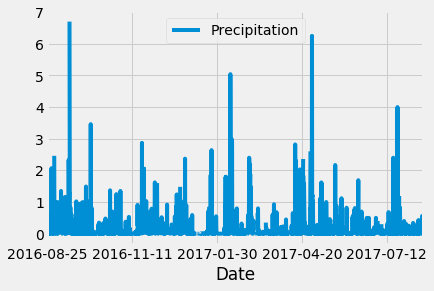

In [58]:
df.plot(x_compat=True)

![precipitation](Images/precipitation.png)

In [59]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,Precipitation
count,2009.000000
mean,0.172344
std,0.452818
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [60]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(Station.station)).all()


[(9)]

In [61]:
station_query = session.query(Station.station).all()
len(station_query)

9

In [62]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [63]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

session.query(func.min(Measurement.tobs),func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

In [64]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

station=session.query(Measurement.tobs).\
      filter(Measurement.station== 'USC00519281').\
      filter(Measurement.date >= query_date).all()
station

station_df = pd.DataFrame(station, columns=['Tempature'])
station_df.head()





,Tempature
0,77.0
1,80.0
2,80.0
3,75.0
4,73.0


<Figure size 1224x720 with 0 Axes>

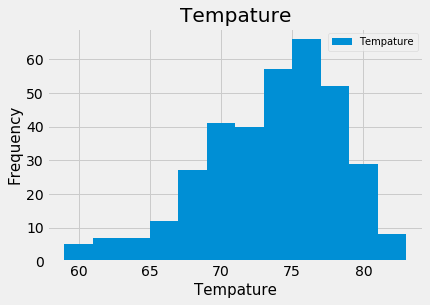

In [65]:
fig=plt.figure(figsize=(17,10))
station_df.hist(column="Tempature",bins=12)
plt.xlabel("Tempature",fontsize=15)
plt.ylabel("Frequency",fontsize=15)
plt.legend(["Tempature"],loc= 'best', prop={'size': 10})
plt.show()
#plt.xlim([60,85])

![precipitation](Images/station-histogram.png)

In [66]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [67]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


prev_year_start = dt.date(2018, 1, 1) - dt.timedelta(days=365)
prev_year_end = dt.date(2018, 1, 7) - dt.timedelta(days=365)

tmin, tavg, tmax = calc_temps(prev_year_start.strftime("%Y-%m-%d"), prev_year_end.strftime("%Y-%m-%d"))[0]
print(tmin, tavg, tmax)


62.0 68.36585365853658 74.0


C:\Users\N_Pos\Anaconda3\envs\PythonData\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


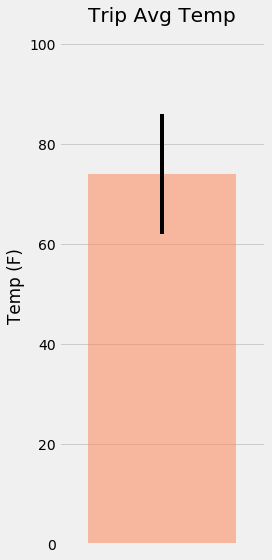

In [68]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


fig, ax = plt.subplots(figsize=plt.figaspect(2.))
xpos = 1
yerr = tmax-tmin

bar = ax.bar(xpos, tmax, yerr=yerr, alpha=0.5, color='coral', align="center")
ax.set(xticks=range(xpos), xticklabels="a", title="Trip Avg Temp", ylabel="Temp (F)")
ax.margins(.2, .2)
# fig.autofmt_xdate()
fig.tight_layout()
fig.show()


In [69]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
start_date = '2012-01-01'
end_date = '2012-01-07'

sel = [Station.station, Station.name, Station.latitude, 
       Station.longitude, Station.elevation, func.sum(Measurement.prcp)]

results = session.query(*sel).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date >= start_date).\
    filter(Measurement.date <= end_date).\
    group_by(Station.name).order_by(func.sum(Measurement.prcp).desc()).all()


results_df = pd.DataFrame(results, columns=['Station ID', 'Station Name', "latitude", "longitude", "Elevation", "Precipitation" ])
results_df


,Station ID,Station Name,latitude,longitude,Elevation,Precipitation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.31
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.25
2,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6,0.10
3,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.06
4,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9,0.00
5,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.00
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,0.00
7,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.00
8,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.00


## Optional Challenge Assignment

In [70]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [71]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [72]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [73]:
# Plot the daily normals as an area plot with `stacked=False`
